# Homework 2: Word Embeddings & Deep Learning for NLP

**Duration**: 7 days | **Total Points**: 100

---

## Grading Rubric

| Section | Points |
|---------|--------|
| Part 1: Theory Questions | 25 |
| Part 2: Word Embeddings | 35 |
| Part 3: Text Classification with LSTM | 30 |
| Part 4: Bonus | 10 |
| **Total** | **100** |

In [1]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from collections import Counter
import gensim.downloader as api

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
print("Ready!")

Device: cpu
Ready!


---
# Part 1: Theory Questions (25 points)

Answer in the markdown cells below.

### Q1.1 (5 pts): What is the main advantage of word embeddings over one-hot encoding?

*Your answer here*

### Q1.2 (5 pts): Explain the "distributional hypothesis" in one sentence.

*Your answer here*

### Q1.3 (5 pts): What problem does LSTM solve that vanilla RNN cannot? Name the mechanism.

*Your answer here*

### Q1.4 (5 pts): What is the purpose of the embedding layer in a neural network?

*Your answer here*

### Q1.5 (5 pts): Why do we use bidirectional LSTMs for text classification?

*Your answer here*

---
# Part 2: Word Embeddings (35 points)

In [2]:
# Load pre-trained GloVe embeddings
print("Loading GloVe (this may take a minute)...")
glove = api.load('glove-wiki-gigaword-100')
print(f"Loaded! Vocabulary: {len(glove):,} words, Dimensions: {glove.vector_size}")

Loading GloVe (this may take a minute)...
Loaded! Vocabulary: 400,000 words, Dimensions: 100


### Task 2.1: Word Analogies (10 pts)

Complete the `analogy` function and find **3 working analogies** of your own.

In [29]:
def analogy(a, b, c, model):
    """
    Solve: a is to b as c is to ?
    Formula: b - a + c = ?
    
    Returns: top 3 results as list of (word, score) tuples
    """

    vec_a = model[a]
    vec_b = model[b] 
    vec_c = model[c]
    

    target_vector = vec_b - vec_a + vec_c
    
    Res = model.most_similar(positive=[vec_c, vec_b], negative=[vec_a])
    

    Top_3 = []
    for word, score in Res:
        if word not in [a, b, c]:
            Top_3.append((word, score))  

    return Top_3[:3]


print("man : king :: woman : ?")
results = analogy('man', 'king', 'woman', glove)
for word, score in results:
    print(f"  {word} (score: {score:.2f})")


print("1. Tokyo : Japan :: Paris : ?")
results = analogy('tokyo', 'japan', 'paris', glove)
for word, score in results:
    print(f"  {word} (score: {score:.2f})")

print("2. walk : walked :: eat : ?")
results = analogy('walk', 'walked', 'eat', glove)
for word, score in results:
    print(f"  {word} (score: {score:.2f})")


print("3. brother : sister :: uncle : ?")
results = analogy('brother', 'sister', 'uncle', glove)
for word, score in results:
    print(f"  {word} (score: {score:.2f})")

print("4. boy : girl :: uncle : ?")
results = analogy('boy', 'girl', 'uncle', glove)
for word, score in results:
    print(f"  {word} (score: {score:.2f})")

print("5. hot : cold :: fast : ?")
results = analogy('hot', 'cold', 'fast', glove)
for word, score in results:
    print(f"  {word} (score: {score:.2f})")
    
print("6. man : doctor :: woman : ?")
results = analogy('man', 'doctor', 'woman', glove)
for word, score in results:
    print(f"  {word} (score: {score:.2f})")    

# TODO: Find 3 more working analogies
# Example categories: countries-capitals, verb tenses, gender relations, etc.

man : king :: woman : ?
  queen (score: 0.78)
  monarch (score: 0.69)
  throne (score: 0.68)
1. Tokyo : Japan :: Paris : ?
  france (score: 0.88)
  french (score: 0.75)
  europe (score: 0.74)
2. walk : walked :: eat : ?
  ate (score: 0.86)
  eaten (score: 0.76)
  eating (score: 0.71)
3. brother : sister :: uncle : ?
  aunt (score: 0.85)
  mother (score: 0.78)
  grandmother (score: 0.78)
4. boy : girl :: uncle : ?
  aunt (score: 0.84)
  daughter (score: 0.83)
  niece (score: 0.81)
5. hot : cold :: fast : ?
  slow (score: 0.67)
  pace (score: 0.60)
  long (score: 0.58)
6. man : doctor :: woman : ?
  nurse (score: 0.78)
  physician (score: 0.71)
  doctors (score: 0.68)


### Task 2.2: Word Clustering Visualization (15 pts)

Select 30 words from 3 different categories, get their embeddings, and visualize with t-SNE.

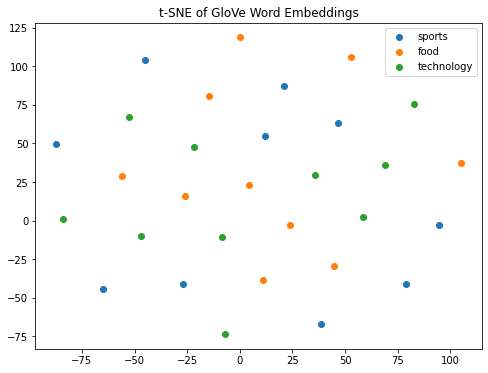

In [5]:
# TODO:
# 1. Define 3 categories with 10 words each (e.g., sports, food, technology)
# 2. Get GloVe vectors for all words
# 3. Apply t-SNE to reduce to 2D
# 4. Create a scatter plot with different colors for each category
# 5. Add a legend

categories = {
    'sports': [
        'football', 'basketball', 'tennis', 'cricket', 'soccer',
        'baseball', 'golf', 'hockey', 'rugby', 'volleyball'
    ],
    'food': [
        'pizza', 'burger', 'rice', 'bread', 'cheese',
        'chicken', 'apple', 'banana', 'pasta', 'cake'
    ],
    'technology': [
        'computer', 'internet', 'software', 'hardware', 'keyboard',
        'mouse', 'screen', 'phone', 'server', 'database'
    ]
}


words = []
vectors = []
labels = []

for cat, ws in categories.items():
    for w in ws:
        if w in glove:        
            words.append(w)
            vectors.append(glove[w])
            labels.append(cat)

X = np.array(vectors)


tsne = TSNE(n_components=2, random_state=42)
TwoDimX = tsne.fit_transform(X)

plt.figure(figsize=(8,6))

for cat in categories.keys():
    I = []
    for i in range(len(labels)):
        if labels[i] == cat:
            I.append(i)

    plt.scatter(TwoDimX[I, 0], TwoDimX[I, 1], label=cat)
    
plt.legend()
plt.title("t-SNE of GloVe Word Embeddings")
plt.show() 

### Task 2.3: Document Similarity (10 pts)

Implement document vectors by averaging word embeddings, then find the most similar document to a query.

In [6]:
documents = [
    "The stock market crashed due to economic recession",
    "Scientists discovered a new planet in distant galaxy",
    "The football team won the championship game",
    "New smartphone features advanced artificial intelligence",
    "The basketball player scored thirty points"
]

def document_vector(text, model):
    words = text.lower().split()
    
    vecs = []
    for w in words:
        if w in model:
            vecs.append(model[w])
            

    if len(vecs) == 0:
        return np.zeros(model.vector_size)

    return np.mean(vecs, axis=0)


def cosine_similarity(a, b):
    dot = np.dot(a, b)
    A = np.sqrt(np.sum(a * a))
    B = np.sqrt(np.sum(b * b))
    return dot / (A * B)


def find_most_similar(query, documents, model):
    
    query_vec = document_vector(query, model)
    index = 0
    Max_score = -1

    for i, doc in enumerate(documents):
        d_vec = document_vector(doc, model)
        score = cosine_similarity(query_vec, d_vec)

        if score > Max_score:
            Max_score = score
            index = i
            

    return index, Max_score

# Test
query = "The soccer match ended in victory"
idx, score = find_most_similar(query, documents, glove)
print(f"Query: {query}")
print(f"Most similar: {documents[idx]}")
print(f"Similarity: {score:.4f}")

Query: The soccer match ended in victory
Most similar: The football team won the championship game
Similarity: 0.9294


---
# Part 3: Text Classification with LSTM (30 points)

Build an LSTM classifier for the dataset below.

In [16]:
# Dataset: Product reviews (positive=1, negative=0)
reviews = [
    ("This product is amazing and works perfectly", 1),
    ("Excellent quality highly recommend to everyone", 1),
    ("Love it best purchase I have made", 1),
    ("Great value for money very satisfied", 1),
    ("Fantastic product exceeded my expectations", 1),
    ("Works great easy to use love it", 1),
    ("Perfect exactly what I was looking for", 1),
    ("High quality product fast shipping thanks", 1),
    ("Terrible product broke after one day", 0),
    ("Waste of money do not buy this", 0),
    ("Very disappointed with the poor quality", 0),
    ("Does not work as advertised useless", 0),
    ("Horrible experience worst purchase ever made", 0),
    ("Cheap quality not worth the price", 0),
    ("Broken on arrival complete waste", 0),
    ("Regret buying this terrible product", 0),
]

texts = [r[0] for r in reviews]
labels = [r[1] for r in reviews]
print(f"Dataset: {len(texts)} samples")

Dataset: 16 samples


### Task 3.1: Data Preparation (10 pts)

Complete the preprocessing pipeline.

In [17]:
def build_vocab(texts):
    """
    Build vocabulary from texts.
    Returns: dict {word: index} with <PAD>=0, <UNK>=1
    """
    vocab = {'<PAD>': 0, '<UNK>': 1}
    idx = 2
    
    for text in texts:
        for word in text.lower().split():
            if word not in vocab:
                vocab[word] = idx
                idx += 1
    return vocab

def text_to_sequence(text, vocab, max_len):
    words = text.lower().split()
    
    out = []         
    for w in words:
        if w in vocab:
            out.append(vocab[w])
        else:
            out.append(1)   
        
    if len(out) < max_len:
        for K in range(max_len - len(out)):
            out.append(0)   

    else:
        out = out[:max_len]
    
    return out

vocab = build_vocab(texts)
max_len = 10
sequences = [text_to_sequence(t, vocab, max_len) for t in texts]

print(f"Vocabulary size: {len(vocab)}")
print(f"Sample: '{texts[0]}' -> {sequences[0]}")

Vocabulary size: 75
Sample: 'This product is amazing and works perfectly' -> [2, 3, 4, 5, 6, 7, 8, 0, 0, 0]


### Task 3.2: LSTM Model (10 pts)

Complete the LSTM classifier.

In [18]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        emb = self.embedding(x)
        out, _ = self.lstm(emb)
        last_out = out[:, -1, :]
        out = self.fc(last_out)
        out = self.sigmoid(out)
        return out

# Create model
model = LSTMClassifier(vocab_size=len(vocab), embedding_dim=32, hidden_dim=64).to(device)
print(model)

LSTMClassifier(
  (embedding): Embedding(75, 32)
  (lstm): LSTM(32, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


### Task 3.3: Training and Evaluation (10 pts)

Train the model and report accuracy on 3 test examples.

Epoch [10/50], Loss: 0.00067240
Epoch [20/50], Loss: 0.00026887
Epoch [30/50], Loss: 0.00016264
Epoch [40/50], Loss: 0.00011361
Epoch [50/50], Loss: 0.00008332


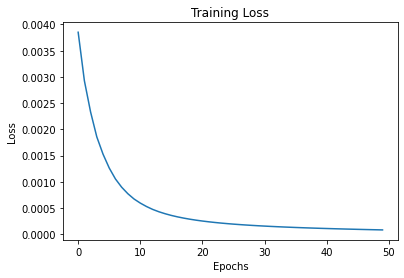

Text: 'Amazing product love it' -> Positive (prob=0.9999)
Text: 'Terrible waste of money' -> Negative (prob=0.0001)
Text: 'Good quality recommended' -> Positive (prob=0.9999)


In [20]:
# TODO:
# 1. Create DataLoader
# 2. Define loss function (BCELoss) and optimizer (Adam)
# 3. Train for 50-100 epochs
# 4. Plot training loss
# 5. Test on these examples:


class ReviewDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

X_train, X_val, y_train, y_val = train_test_split(sequences, labels, test_size=0.2, random_state=42)
train_dataset = ReviewDataset(X_train, y_train)
val_dataset = ReviewDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)


criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 50
train_losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.8f}")


plt.plot(train_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

test_examples = [
    "Amazing product love it",
    "Terrible waste of money",
    "Good quality recommended"
]

model.eval()
test_seq = [text_to_sequence(t, vocab, max_len) for t in test_examples]
test_seq = torch.tensor(test_seq, dtype=torch.long).to(device)

with torch.no_grad():
    preds = model(test_seq)
    preds = preds.cpu().numpy()

for text, pred in zip(test_examples, preds):
    label = "Positive" if pred[0] > 0.5 else "Negative"
    print(f"Text: '{text}' -> {label} (prob={pred[0]:.4f})")







---
# Part 4: Bonus (10 points)

**Choose ONE:**

**A)** Initialize your LSTM embedding layer with GloVe vectors and compare performance with random initialization.

**B)** Implement a GRU classifier instead of LSTM and compare the number of parameters.

**C)** Find and explain 2 examples where word embeddings show bias (e.g., gender, racial).

In [ ]:
# Your bonus solution here

---
## Submission Checklist

- [ ] All code runs without errors
- [ ] All 5 theory questions answered
- [ ] 3 word analogies found
- [ ] t-SNE visualization complete
- [ ] LSTM model trained and tested

**Good luck!**